# PBMA Ayagari

This notebook aims to illustrate Present-bias with Mixed Actions(PBMA) in the context of Ayagari 1994 model.

In Aiyagari 1994 model, uninsured idiosyncratic income shocks cannot generate a fat-tailed wealth distribution under plausible parameters.

What happens if agents are having PBMA?

## Imports

Here are the imports.

In [1]:
import time
import jax
import jax.numpy as jnp
import numpy as np
from collections import namedtuple
import matplotlib.pyplot as plt
from scipy.optimize import bisect
jax.config.update("jax_enable_x64", True)

We use the following function to compute stationary distribution.

In [3]:
@jax.jit
def compute_stationary(P):
    n = P.shape[0]
    I = jnp.identity(n)
    O = jnp.ones((n, n))
    A = I - jnp.transpose(P) + O
    return jnp.linalg.solve(A, jnp.ones(n))

## Households

Households have the following characteristics:

- infinitely lived
- ex-ante identical
- face an uninsurable idiosyncratic labor income shocks
- face a borrowing constraint
- with a short-run discount factor $\beta$ and a long-run discount factor $\delta$ and $\beta\neq\delta$.

The saving problem faced by a typical household is

$$
\max_{\{c_t\}_{t\ge 0}} \mathbb{E} \left[u(c_0)+ \beta\sum_{t=1}^\infty\delta^t u(c_t)\right]
$$

subject to

$$
a_{t+1}+c_t\le wz_t +(1+r)a_t, \quad c_t\ge 0,\quad a_t\le -B
$$

where
- $c_t$ is the current consumption
- $a_t$ is asset holding
- $z_t$ is an exogenous conponent of labor income capturing stochastic unemployment risk
- $w$ is the wage
- $r$ is the interest rate
- $B$ is the maximum amount that the agent is allowed the borrow.

Now we setup the household parameters.

In [4]:
Household = namedtuple('Household',
                       ('β', # short-run discount factor
                        'δ', # continuation discount factor
                        'a_grid', 'z_grid', 'Π'))

In [5]:
def create_household(β=0.5,                      # short-run discount factor
                     δ=0.96,                       # continuation discount factor
                     Π=[[0.9, 0.1], [0.1, 0.9]],  # Markov chain
                     z_grid=[0.1, 1.0],           # Exogenous states
                     a_min=1e-10, a_max=20,       # Asset grid
                     a_size=200):
    """
    Create a namedtuple that stores all data needed to solve the household
    problem, given prices.

    """
    a_grid = jnp.linspace(a_min, a_max, a_size)
    z_grid, Π = map(jnp.array, (z_grid, Π))
    return Household(β=β, δ=δ, a_grid=a_grid, z_grid=z_grid, Π=Π)

We assume log utility, i.e.,

In [6]:
u = jnp.log

Here’s a tuple that stores the wage rate and interest rate, as well as a function that creates a price namedtuple with default values.

In [7]:
Prices = namedtuple('Prices', ('r', 'w'))

def create_prices(r=0.01,   # Interest rate
                  w=1.0):   # Wages
    return Prices(r=r, w=w)

### Compute Continuation Value Function

In this section, we compute the continuation value function.


We set the Bellman aggregator for the continuation value problem, which is as follows

$$
B(a,z,a') = u(\underbrace{wz+(1+r)a-a'}_{\text{consumption}}) + \delta \sum_{z'}v(a',z')\Pi(z,z')
$$
for all $(a,z,a')$.

Note that here we use the long-run discount factor $\delta$ to find the continuation value function.


Moreover, since the optimal continuation policy is a stationary policy, here we use the classical DP methods to find the optimal continuation policy.



In [8]:
@jax.jit
def B(v, household, prices):
    # Unpack
    β, δ, a_grid, z_grid, Π = household
    a_size, z_size = len(a_grid), len(z_grid)
    r, w = prices

    # Compute current consumption as array c[i, j, ip]
    a  = jnp.reshape(a_grid, (a_size, 1, 1))    # a[i]   ->  a[i, j, ip]
    z  = jnp.reshape(z_grid, (1, z_size, 1))    # z[j]   ->  z[i, j, ip]
    ap = jnp.reshape(a_grid, (1, 1, a_size))    # ap[ip] -> ap[i, j, ip]
    c = w * z + (1 + r) * a - ap

    # Calculate continuation rewards at all combinations of (a, z, ap)
    v = jnp.reshape(v, (1, 1, a_size, z_size))  # v[ip, jp] -> v[i, j, ip, jp]
    Π = jnp.reshape(Π, (1, z_size, 1, z_size))  # Π[j, jp]  -> Π[i, j, ip, jp]
    EV = jnp.sum(v * Π, axis=-1)                 # sum over last index jp

    # Compute the right-hand side of the Bellman equation
    return jnp.where(c > 0, u(c) + δ * EV, -jnp.inf)

The next function computes the greedy policies.

In [9]:
@jax.jit
def get_greedy(v, household, prices):
    """
    Computes a v-greedy policy σ, returned as a set of indices.  If
    σ[i, j] equals ip, then a_grid[ip] is the maximizer at i, j.

    """
    return jnp.argmax(B(v, household, prices), axis=-1) # argmax over ap

The following function computes the arrary $r_\sigma$ which gives current rewards given stationary policy $\sigma$.



In [10]:
@jax.jit
def compute_r_σ(σ, household, prices):
    """
    Compute current rewards at each i, j under policy σ.  In particular,

        r_σ[i, j] = u((1 + r)a[i] + wz[j] - a'[ip])

    when ip = σ[i, j].

    """
    # Unpack
    β, δ, a_grid, z_grid, Π = household
    a_size, z_size = len(a_grid), len(z_grid)
    r, w = prices

    # Compute r_σ[i, j]
    a = jnp.reshape(a_grid, (a_size, 1))
    z = jnp.reshape(z_grid, (1, z_size))
    ap = a_grid[σ]
    c = (1 + r) * a + w * z - ap
    r_σ = u(c)

    return r_σ

The continuation $\sigma$-value function $v_\sigma$ is defined as

$$
v_\sigma  = (I-\delta P_\sigma)^{-1} r_\sigma
$$

To compute this vector, we set up the linear map $v\mapsto R_\sigma v$ where $R_\sigma:= I-\delta P_\sigma$.

This map can be expressed as

$$
(R_\sigma v)(a,z) = v(a,z) -\delta \sum_{z'} v(\sigma(a,z),z')\Pi(z,z')
$$

In [11]:
@jax.jit
def R_σ(v, σ, household):
    # Unpack
    β, δ, a_grid, z_grid, Π = household
    a_size, z_size = len(a_grid), len(z_grid)

    # Set up the array v[σ[i, j], jp]
    zp_idx = jnp.arange(z_size)
    zp_idx = jnp.reshape(zp_idx, (1, 1, z_size))
    σ = jnp.reshape(σ, (a_size, z_size, 1))
    V = v[σ, zp_idx]

    # Expand Π[j, jp] to Π[i, j, jp]
    Π = jnp.reshape(Π, (1, z_size, z_size))

    # Compute and return v[i, j] - δ Σ_jp v[σ[i, j], jp] * Π[j, jp]
    return v - δ * jnp.sum(V * Π, axis=-1)

The next function computes the continuation value of a given policy.

In [12]:
@jax.jit
def get_value(σ, household, prices):
    """
    Get the continuation value of policy σ by computing

        v_σ = R_σ^{-1} r_σ

    """
    r_σ = compute_r_σ(σ, household, prices)
    # Reduce R_σ to a function in v
    _R_σ = lambda v: R_σ(v, σ, household)
    # Compute v_σ = R_σ^{-1} r_σ using an iterative routing.
    return jax.scipy.sparse.linalg.bicgstab(_R_σ, r_σ)[0]

Here is the Howard Policy Iteration.

In [13]:
def howard_policy_iteration(household, prices,
                            tol=1e-4, max_iter=10_000, verbose=False):
    """
    Howard policy iteration routine.

    """
    β, δ, a_grid, z_grid, Π = household
    a_size, z_size = len(a_grid), len(z_grid)
    σ = jnp.zeros((a_size, z_size), dtype=int)

    v_σ = get_value(σ, household, prices)
    i = 0
    error = tol + 1
    while error > tol and i < max_iter:
        σ_new = get_greedy(v_σ, household, prices)
        v_σ_new = get_value(σ_new, household, prices)
        error = jnp.max(jnp.abs(v_σ_new - v_σ))
        σ = σ_new
        v_σ = v_σ_new
        i = i + 1
        if verbose:
            print(f"Concluded loop {i} with error {error}.")
    return σ, v_σ

### Compute the Lifetime Value Function.

Compute the lifetime value function is by solving a two-period DP problem. The continuation value is the continuation value function $v_c$ obtained from the HPI.


The Bellman aggregator for this part of the problem is shown below:

$$
B_0(a,z,a') = u(\underbrace{wz+(1+r)a-a'}_{\text{consumption}}) + \beta\delta \sum_{z'}v_c(a',z')\Pi(z,z')
$$
for all $(a,z,a')$.

We can obtain the short-run optimal policy by finding the maximum for each $(a,z)$.

Here we have for $B_0$

In [14]:
@jax.jit
def B_0(v, household, prices):
    # Unpack
    β, δ, a_grid, z_grid, Π = household
    a_size, z_size = len(a_grid), len(z_grid)
    r, w = prices

    # Compute current consumption as array c[i, j, ip]
    a  = jnp.reshape(a_grid, (a_size, 1, 1))    # a[i]   ->  a[i, j, ip]
    z  = jnp.reshape(z_grid, (1, z_size, 1))    # z[j]   ->  z[i, j, ip]
    ap = jnp.reshape(a_grid, (1, 1, a_size))    # ap[ip] -> ap[i, j, ip]
    c = w * z + (1 + r) * a - ap

    # Calculate continuation rewards at all combinations of (a, z, ap)
    v = jnp.reshape(v, (1, 1, a_size, z_size))  # v[ip, jp] -> v[i, j, ip, jp]
    Π = jnp.reshape(Π, (1, z_size, 1, z_size))  # Π[j, jp]  -> Π[i, j, ip, jp]
    EV = jnp.sum(v * Π, axis=-1)                 # sum over last index jp

    # Compute the right-hand side of the Bellman equation
    return jnp.where(c > 0, u(c) + β * δ * EV, -jnp.inf)

We also need new



*   `get_greedy` function.
*   `R_σ` function
-   `get_value` function

by change  δ to β




In [15]:
@jax.jit
def get_greedy_0(v, household, prices):
    """
    Computes a v-greedy policy σ, returned as a set of indices.  If
    σ[i, j] equals ip, then a_grid[ip] is the maximizer at i, j.

    """
    return jnp.argmax(B_0(v, household, prices), axis=-1)


@jax.jit
def R_σ_0(v, σ, household):
    # Unpack
    β, δ, a_grid, z_grid, Π = household
    a_size, z_size = len(a_grid), len(z_grid)

    # Set up the array v[σ[i, j], jp]
    zp_idx = jnp.arange(z_size)
    zp_idx = jnp.reshape(zp_idx, (1, 1, z_size))
    σ = jnp.reshape(σ, (a_size, z_size, 1))
    V = v[σ, zp_idx]

    # Expand Π[j, jp] to Π[i, j, jp]
    Π = jnp.reshape(Π, (1, z_size, z_size))

    # Compute and return v[i, j] - δ Σ_jp v[σ[i, j], jp] * Π[j, jp]
    return v - β * δ * jnp.sum(V * Π, axis=-1)

@jax.jit
def get_value_0(σ, household, prices):
    """
    Get the continuation value of policy σ by computing

        v_σ = R_σ^{-1} r_σ

    """
    r_σ = compute_r_σ(σ, household, prices)
    # Reduce R_σ to a function in v
    _R_σ_0 = lambda v: R_σ_0(v, σ, household)
    # Compute v_σ = R_σ^{-1} r_σ using an iterative routing.
    return jax.scipy.sparse.linalg.bicgstab(_R_σ_0, r_σ)[0]

Then, we can find the $v_c$-greedy policy use the previous `get_greedy()` function.

This gives the $v_c$-greedy policy over the short-run policy operators.

And we then can apply the `get_value()` function to get the lifetime value function.

Hence, this allows us to get the PMBA lifetime value function and optimal policy pair.

The following function combines the computation for lifetime value function into one function.

In [16]:
def compute_lifetime(household, prices):
  # Unpack
    β, δ, a_grid, z_grid, Π = household
    a_size, z_size = len(a_grid), len(z_grid)
    r, w = prices

  # get continuation value function and optimal continuation policy using HPI
    σ_c, v_c = howard_policy_iteration(household, prices)

  # Compute the v_c-greedy policy using get_greedy_0
    σ_star = get_greedy_0(v_c, household, prices)

  # Compute the lifetime value function
    v_star = get_value_0(σ_star, household, prices)
    return σ_star, v_star


## Firm Dynamics

Consider the representative firm with

$$
Y = AK^{\alpha} N^{1-\alpha}
$$

The firm's problem is to solve the following static optimization problem:

$$
\max_{K,N} \{AK^{\alpha} N^{1-\alpha} - (r+\delta) K - wN\}
$$

i.e., the firm chooses capital and labor demand to maximize total profit. This give the following first-order conditions.

The first-order condition with respect to capital demanded:

\begin{equation}
r = A\alpha\left(\frac{N}{K}\right)^{1-\alpha}-\delta
\end{equation}



The first-order condition with respect to labor demanded:

$$
w = A(1-\alpha) \left(\frac{K}{N}\right)^{\alpha}
$$

where



*   $Y$ is the total output
*   $K$ is the total capital demanded by the firm
-   $N$ is the total labor demanded by the firm
-   $\alpha$ is the capital share, a parameter with $\alpha\in(0,1)$

-   $\delta$ is the depreciation rate, a parameter with $\delta\in(0,1)$

-   $r$ is the interest rate
-   $w$ is the wage price of labor



Now we store the parameters in the following namedtuple:

In [17]:
Firm = namedtuple('Firm', ('A', 'N', 'α', 'δ'))

def create_firm(A=1.0,
                N=1.0,
                α=0.33,
                δ=0.05):
    """
    Create a namedtuple that stores firm data.

    """
    return Firm(A=A, N=N, α=α, δ=δ)

Here is the interest rate associated with a given demand for capital

In [18]:
def r_given_k(K, firm):
    """
    Inverse demand curve for capital.  The interest rate associated with a
    given demand for capital K.
    """
    A, N, α, δ = firm
    return A * α * (N / K)**(1 - α) - δ

Here is the first-order condition for wages associate with a given interest rate

In [19]:
def r_to_w(r, firm):
    """
    Equilibrium wages associated with a given interest rate r.
    """
    A, N, α, δ = firm
    return A * (1 - α) * (A * α / (r + δ))**(α / (1 - α))

## Solve the Equilibrium

Under PBMA, there are two equilibria, one for the short-run policy and one for the continuation policy.

When the agent finds out their type at the beginning of each period -- whether use $\delta$ or $\beta\delta$ as their discount factor -- this leads to different types of equilibium level of capital.

One justification for this two equilibria is that both are rational expectation equilibrium because all the changes in the discount factors is considered as unexpected, or behavioral shocks.


In the equilibrium, the capital supply equals the capital demand.

First, we compute the stationary distribution of a given policy and then compute the capital supply for the short-run policy, i.e., using the short-run policy.

In [20]:
@jax.jit
def compute_asset_stationary(σ, household):
    # Unpack
    β, δ, a_grid, z_grid, Π = household
    a_size, z_size = len(a_grid), len(z_grid)

    # Construct P_σ as an array of the form P_σ[i, j, ip, jp]
    ap_idx = jnp.arange(a_size)
    ap_idx = jnp.reshape(ap_idx, (1, 1, a_size, 1))
    σ = jnp.reshape(σ, (a_size, z_size, 1, 1))
    A = jnp.where(σ == ap_idx, 1, 0)
    Π = jnp.reshape(Π, (1, z_size, 1, z_size))
    P_σ = A * Π

    # Reshape P_σ into a matrix
    n = a_size * z_size
    P_σ = jnp.reshape(P_σ, (n, n))

    # Get stationary distribution and reshape back onto [i, j] grid
    ψ = compute_stationary(P_σ)
    ψ = jnp.reshape(ψ, (a_size, z_size))

    # Sum along the rows to get the marginal distribution of assets
    ψ_a = jnp.sum(ψ, axis=1)
    return ψ_a

Then, the following function computes aggregate capital supply.

In [21]:
def capital_supply(σ, household):
    """
    Induced level of capital stock under the policy, taking r and w as given.

    """
    β, δ, a_grid, z_grid, Π = household
    ψ_a = compute_asset_stationary(σ, household)
    return float(jnp.sum(ψ_a * a_grid))

The procedure to compute a stationary rational expectation equilibrium is shown below:




1.   Set $n=0$, start with inital guess $K_0$ for aggregate capital
2.   Determine prices, $r$ and $w$, from the firm decision problem, given $K_n$
3.   Compute the optimal saving policy of the household given these prices
4.   Compute aggregate capital $K_{n+1}$ as the mean of steady state capital given this saving policy
5.   If $K_{n+1}\approx K_n$, stop, otherwise back to step 2.


We can write the sequence of operations in step 2-4 as

$$
K_{n+1} = G(K_n)
$$

In other words, our problem is to find the fixed-point of the one-dimensional map $G$.

In [22]:
def G_short(K, firm, household):
    # Get prices r, w associated with K
    r = r_given_k(K, firm)
    w = r_to_w(r, firm)
    # Generate a household object with these prices, compute
    # aggregate capital.
    prices = create_prices(r=r, w=w)
    σ_star, v_star = compute_lifetime(household, prices)

    return capital_supply(σ_star, household)

Now we compute the equilibrium using the above algorithm. Moreover, we use damped iteration scheme of the following form

$$
K_{n+1} = \gamma K_n + (1-\gamma) G(K_n)
$$

The next function is for computing the equilibrium.

In [23]:
def compute_equilibrium_short(firm, household,
                        K0=6, γ=0.99, max_iter=1_000, tol=1e-4,
                        print_skip=10, verbose=False):
    n = 0
    K = K0
    error = tol + 1
    while error > tol and n < max_iter:
        new_K = γ * K + (1 - γ) * G_short(K, firm, household)
        error = abs(new_K - K)
        K = new_K
        n += 1
        if verbose and n % print_skip == 0:
            print(f"At iteration {n} with error {error}")
    return K, n

Now let's compute the equilibrium associated with short-run policy.

In [24]:
firm = create_firm()
household = create_household()
print("\nComputing equilibrium capital stock")
start = time.time()
K_star, n = compute_equilibrium_short(firm, household, K0=6.0, verbose=True)
elapsed = time.time() - start
print(f"Computed equilibrium with short-run policy {K_star:.5} in {n} iterations and {elapsed} seconds")


Computing equilibrium capital stock
At iteration 10 with error 0.04264585937555054
At iteration 20 with error 0.035350521505255195
At iteration 30 with error 0.02849626323452714
At iteration 40 with error 0.0221610876641245
At iteration 50 with error 0.016997040719201273
At iteration 60 with error 0.012664700910607785
At iteration 70 with error 0.009499649295577228
At iteration 80 with error 0.0069715333155881964
At iteration 90 with error 0.005015429049663567
At iteration 100 with error 0.0033146145265896543
At iteration 110 with error 0.0023908259326983483
At iteration 120 with error 0.001734370411104802
At iteration 130 with error 0.001030451308086544
At iteration 140 with error 0.0007433637839948659
At iteration 150 with error 0.0005318467715782482
At iteration 160 with error 0.0001808090574519916
At iteration 170 with error 0.0001635204705587867
At iteration 180 with error 0.00012761969758612324
At iteration 190 with error 0.00011541696691486081
At iteration 200 with error 0.0001

### Equilibrium associated with the continuation policy

We change

- `G_short` to `G_continuation`

- `compute_equilibrium_short` to `compute_equilibrium_continuation`

First, we get the  `G_continuation`

In [24]:
def G_continuation(K, firm, household):
    # Get prices r, w associated with K
    r = r_given_k(K, firm)
    w = r_to_w(r, firm)
    # Generate a household object with these prices, compute
    # aggregate capital.
    prices = create_prices(r=r, w=w)

    # this gives us the continuation policy
    σ_c, v_c = howard_policy_iteration(household, prices)

    return capital_supply(σ_c, household)

Then, we get  `compute_equilibrium_continuation`

In [25]:
def compute_equilibrium_continuation(firm, household,
                        K0=6, γ=0.99, max_iter=1_000, tol=1e-4,
                        print_skip=10, verbose=False):
    n = 0
    K = K0
    error = tol + 1
    while error > tol and n < max_iter:
        new_K = γ * K + (1 - γ) * G_continuation(K, firm, household)
        error = abs(new_K - K)
        K = new_K
        n += 1
        if verbose and n % print_skip == 0:
            print(f"At iteration {n} with error {error}")
    return K, n

## Stationary Asset Distribution at equilibrium.

### For the short-run policy equilibrium

For the short-run policy, we use the following function to plot the stationary asset distribution.  

In [26]:
def plot_asset_distribution_short(firm, household):

  # First, get the short-run policy Equilibrium (SRPE) Capital, interest rate, wage
  K_star, n = compute_equilibrium_short(firm, household)
  r = r_given_k(K_star, firm)
  w = r_to_w(r, firm)

  # Compute the SRPE prices
  prices = create_prices(r=r, w=w)

  # Compute lifetime value function and optimal policy
  σ_star, v_star = compute_lifetime(household, prices)

  # asset distribution at SRPE
  ψ = compute_asset_stationary(σ_star, household)

  # plot the stationary asset distribution at  SRPE
  fig, ax = plt.subplots()
  ax.bar(household.a_grid, ψ)
  ax.set_xlabel("asset level")
  ax.set_ylabel("Probability Mass")
  ax.set_title("stationary asset distribution at SRPE")
  plt.show()

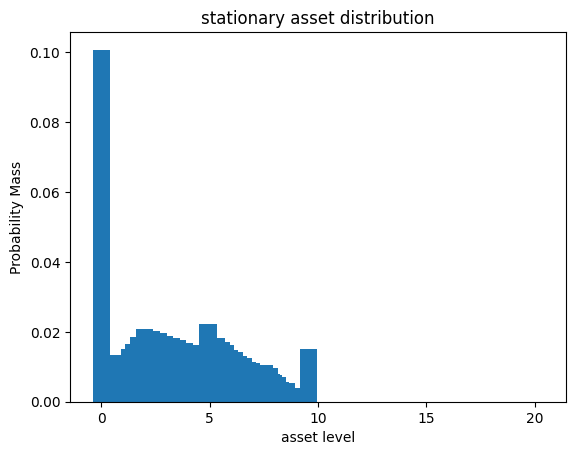

In [26]:
plot_asset_distribution_short(firm, household)

### For the continuation policy equilibrium

Similarly, we modified the above function to plot the continuation policy equilibrium (CPE)

In [27]:
def plot_asset_distribution_continuation(firm, household):

  # First, get the CPE Capital, interest rate, wage
  K_star, n = compute_equilibrium_continuation(firm, household)
  r = r_given_k(K_star, firm)
  w = r_to_w(r, firm)

  # Compute the CPE prices
  prices = create_prices(r=r, w=w)

  # Compute lifetime value function and optimal policy
  σ_c, v_c = howard_policy_iteration(household, prices)

  # asset distribution at CPE
  ψ = compute_asset_stationary(σ_c, household)

  # plot the stationary asset distribution at  CPE
  fig, ax = plt.subplots()
  ax.bar(household.a_grid, ψ)
  ax.set_xlabel("asset level")
  ax.set_ylabel("Probability Mass")
  ax.set_title("stationary asset distribution at CPE")
  plt.show()

## What happens with the Mixed Action?

The mixed actions represent the behavioral aspect of the agent.

- there is an unexpected shock with a probability $\omega$ that the agent will have discount factor $\beta\delta$ instead of $\delta$ at the beginning of each period.

- this probability $\omega$ represents the parameter of self-control.

- With probability $1-\omega$, agents can control themselves to stay with discount factor $\delta$.

### What happens to the equilibrium?

There will be two equilibrium.

- SRPE is the equilibrium level when agents find that their discount factor is $\beta\delta$

- CPE is the equilibrium level when agents find that their discount factor is $\delta$

### What happens to the stationary asset distribution?

There are two stationary asset distribution corresponding to each equilibrium.

Another way to look at stationary distribution is using a weighted average of these two Markov matrices.

Denote $P_{short}$ as the Markov matrix for the short-run policy.

Denote $P_{continuation}$ as the Markov matrix for the continuation policy.

Then, since we know that with probability $\omega$, we will apply $P_{short}$ and probability $1-\omega$ to apply $P_{continuation}$, we have

$$
P_{MA} = \omega P_{short} + (1-\omega) P_{continuation}
$$

Here we find the stationary distribution of $P_{MA}$

### Stationary distribution for the Mixed Actions

First, we use the following function to compute the mixed stationary distribution.

ω

In [34]:
@jax.jit
def compute_asset_stationary_mixed(σ_s, # short-run policy
                                   σ_c, # continuation policy
                                   household,
                                   ω=0.0 # self-control parameter
                                   ):
    # Unpack
    β, δ, a_grid, z_grid, Π = household
    a_size, z_size = len(a_grid), len(z_grid)

    # Construct P_σ as an array of the form P_σ[i, j, ip, jp]
    ap_idx = jnp.arange(a_size)
    ap_idx = jnp.reshape(ap_idx, (1, 1, a_size, 1))

    σ_s = jnp.reshape(σ_s, (a_size, z_size, 1, 1))
    σ_c = jnp.reshape(σ_c, (a_size, z_size, 1, 1))

    A_s = jnp.where(σ_s == ap_idx, 1, 0)
    A_c = jnp.where(σ_c == ap_idx, 1, 0)

    Π = jnp.reshape(Π, (1, z_size, 1, z_size))

    P_σ_s = A_s * Π
    P_σ_c = A_c * Π

    P_σ = ω * P_σ_s + (1 - ω) * P_σ_c   # Mixed action Markov matrix

    # Reshape P_σ into a matrix
    n = a_size * z_size
    P_σ = jnp.reshape(P_σ, (n, n))

    # Get stationary distribution and reshape back onto [i, j] grid
    ψ = compute_stationary(P_σ)
    ψ = jnp.reshape(ψ, (a_size, z_size))

    # Sum along the rows to get the marginal distribution of assets
    ψ_a = jnp.sum(ψ, axis=1)
    return ψ_a

Now, we use the following function to plot the stationary distribution for the mixed action markov matrix.

In [38]:
def plot_asset_distribution_mixed(firm, household, ω=0.0):

  # First, get the CPE Capital, interest rate, wage
  K_continuation, n = compute_equilibrium_continuation(firm, household)
  r_continuation = r_given_k(K_continuation, firm)
  w_continuation = r_to_w(r_continuation, firm)

  # Compute the CPE prices
  prices_continuation = create_prices(r=r_continuation, w=w_continuation)

  # Compute lifetime value function and optimal policy
  σ_c, v_c = howard_policy_iteration(household, prices_continuation)


  K_short, n = compute_equilibrium_short(firm, household)
  r_short = r_given_k(K_short, firm)
  w_short = r_to_w(r_short, firm)

  # Compute the SRPE prices
  prices_short = create_prices(r=r_short, w=w_short)

  # Compute lifetime value function and optimal policy
  σ_s, v_s = compute_lifetime(household, prices_short)

  # asset distribution with mixed actions
  ψ = compute_asset_stationary_mixed(σ_s, σ_c, household, ω)

  # plot the stationary asset distribution at  CPE
  fig, ax = plt.subplots()
  ax.bar(household.a_grid, ψ)
  ax.set_xlabel("asset level")
  ax.set_ylabel("Probability Mass")
  ax.set_title("stationary asset distribution with Mixed Actions")
  plt.show()

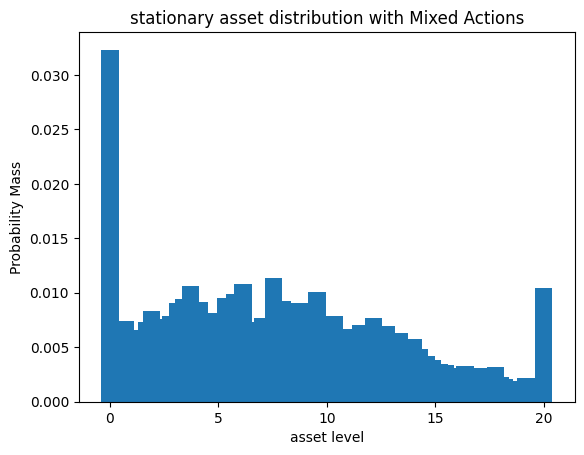

In [36]:
firm = create_firm()
household = create_household()
plot_asset_distribution_mixed(firm, household, ω=0.0)

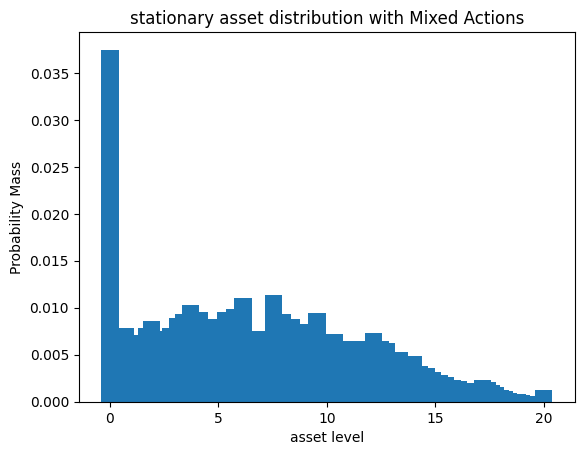

In [39]:
plot_asset_distribution_mixed(firm, household, ω=0.1)

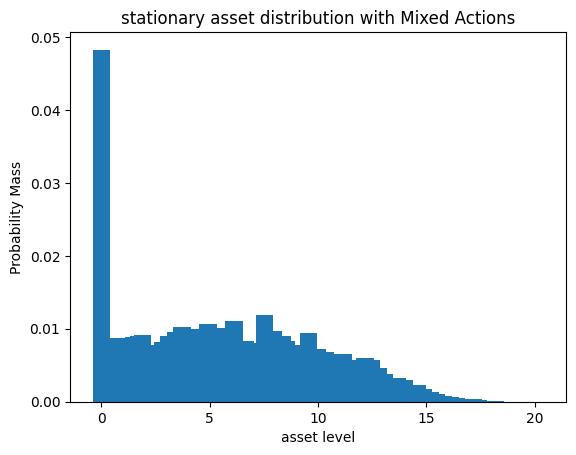

In [40]:
plot_asset_distribution_mixed(firm, household, ω=0.3)

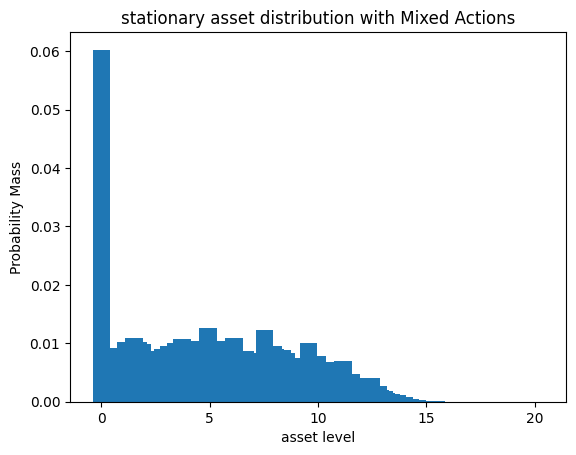

In [41]:
plot_asset_distribution_mixed(firm, household, ω=0.5)

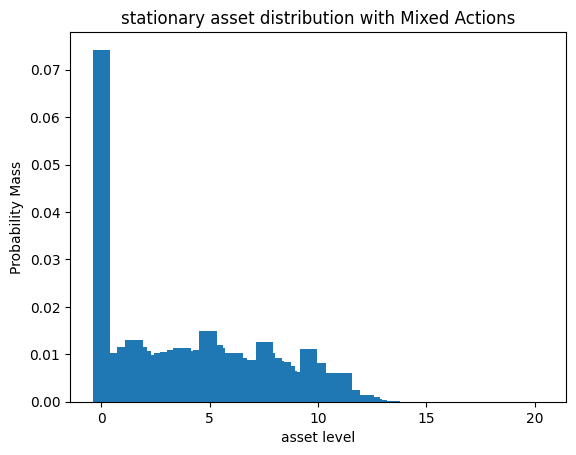

In [42]:
plot_asset_distribution_mixed(firm, household, ω=0.7)

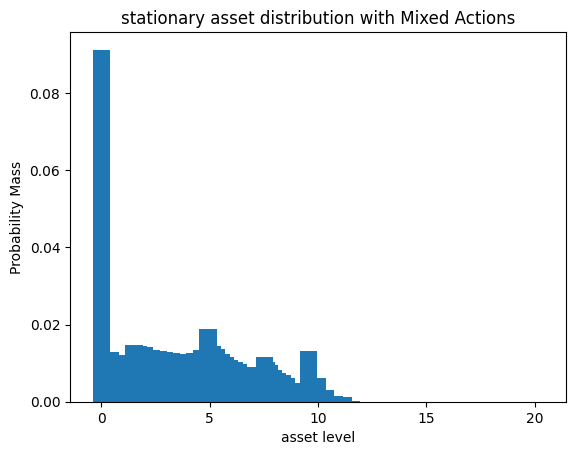

In [43]:
plot_asset_distribution_mixed(firm, household, ω=0.9)

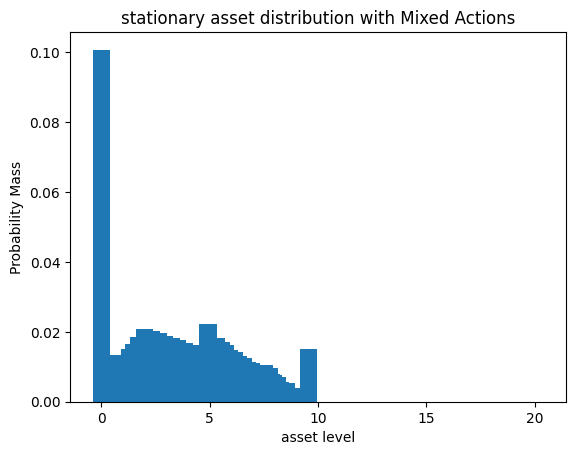

In [44]:
plot_asset_distribution_mixed(firm, household, ω=1)